<a href="https://colab.research.google.com/github/jacobrast/attacks/blob/main/shadow_attack_march_31.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## Step 1: Download the model and dataset

In [1]:
!pip install datasets --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.6 MB/s eta 0:00:00


In [3]:
## Step 2: Run the model on a specific data point
### Jacob's comment March 31 2024: It seems most of this work is already done for me

In [2]:
!git clone https://github.com/hncszyq/ShadowAttack.git

from google.colab import drive
drive.mount('/content/drive')

!unzip -q /content/drive/MyDrive/data/dataset.zip -d /content/ShadowAttack/dataset
!unzip -q /content/drive/MyDrive/data/model.zip -d /content/ShadowAttack/model

!pip install grad-cam --quiet

import sys
import os

directory_path = '/content/ShadowAttack'
sys.path.append(directory_path)
os.chdir('/content/ShadowAttack')

Cloning into 'ShadowAttack'...
remote: Enumerating objects: 819, done.
remote: Counting objects: 100% (819/819), done.
remote: Compressing objects: 100% (795/795), done.
remote: Total 819 (delta 33), reused 792 (delta 15), pack-reused 0
Receiving objects: 100% (819/819), 10.73 MiB | 18.07 MiB/s, done.
Resolving deltas: 100% (33/33), done.
Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 25.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 62.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 91.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.4 MB/s eta 0:00:00
     ━━━━━

In [3]:
import cv2
import json
import torch

import numpy as np
import matplotlib.pyplot as plt

from gtsrb import GtsrbCNN
from utils import load_mask

from gtsrb import test_single_image, pre_process_image
from torchvision import transforms
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import scale_cam_image, show_cam_on_image

In [4]:
from PIL import Image
import tempfile

def pred_image(pil_file, label):
    with tempfile.NamedTemporaryFile(suffix='.png', delete=False) as tmpfile:
        pil_file.save(tmpfile, format='PNG')

        label, correct = test_single_image(tmpfile.name, label)

    return label

In [5]:
from datasets import load_dataset

dataset = load_dataset('bazyl/GTSRB')

with open('params.json', 'rb') as f:
    params = json.load(f)
    class_n = params['GTSRB']['class_n']
    device = params['device']
    position_list, mask_list = load_mask()

# Load the model
model = GtsrbCNN(n_class=class_n).to(device)
model.load_state_dict(
    torch.load(f'./model/model_gtsrb.pth',
                map_location=torch.device(device)))
model.eval()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/39209 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/12630 [00:00<?, ? examples/s]

GtsrbCNN(
  (color_map): Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1))
  (module1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
  )
  (module2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
  )
  (module3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1,

In [6]:
### This is an aside. It is exclusively for finding large images to visualize

In [7]:
my_list = (dataset['train']['Width'])
indices = [index for index, element in enumerate(my_list) if element > 126]


In [433]:
len(indices)

759

In [ ]:
indices

In [631]:
import random
rand_int = random.randint(0, len(indices))

img_index = indices[rand_int]


In [632]:
img = dataset['train'][img_index]['Path']
label = dataset['train'][img_index]['ClassId']

pred_image(img, label)

Correct: True Predict: 30 Confidence: 84.43388938903809%


30

In [9]:
## Step 3: Attack that datapoint to create an adversarially modified image

In [3]:
with tempfile.NamedTemporaryFile(suffix='.png', delete=False) as tmpfile:
    img.save(tmpfile, format='PNG')

NameError: name 'tempfile' is not defined

In [160]:
# !python shadow_attack.py --shadow_level 0.43 --attack_db GTSRB --attack_type physical --image_path ./tmp/gtsrb_30.png --mask_path ./tmp/gtsrb_30_mask.png --image_label 1

In [161]:
### Hmm... need to create a mask file. How to do so?

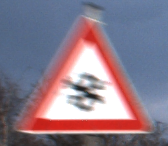

In [634]:
img

In [ ]:
import torch
import torchvision

import sys
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [2]:
image = cv2.imread(tmpfile.name)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

NameError: name 'tmpfile' is not defined

In [ ]:
image

In [545]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

In [ ]:
masks = mask_generator.generate(image)

In [ ]:
masks

In [548]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

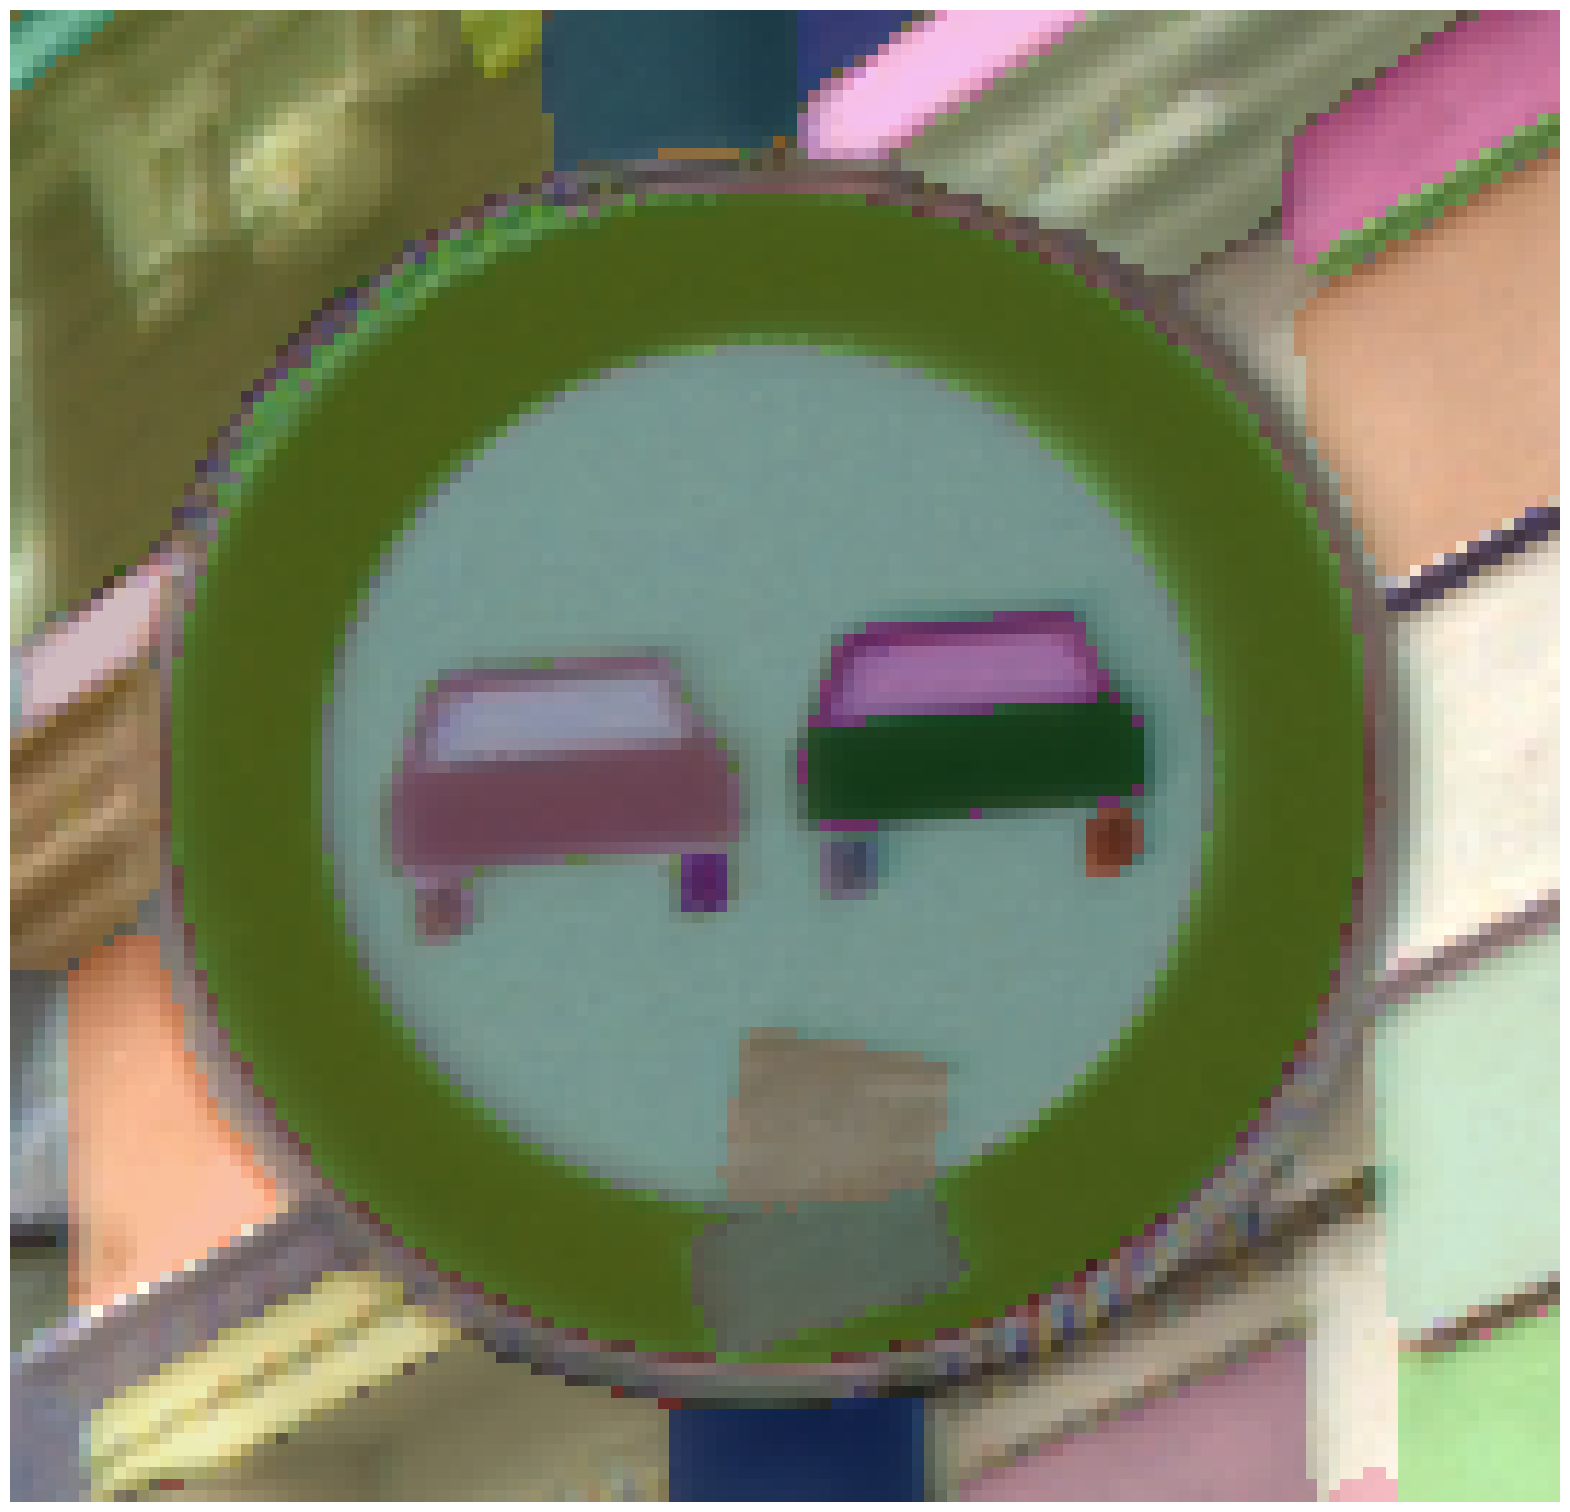

In [549]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

In [550]:
max_index = 0

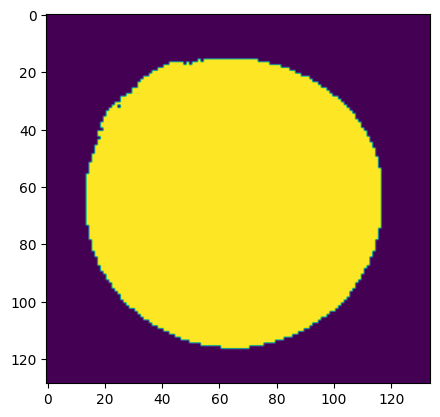

In [551]:
plt.imshow(masks[max_index]['segmentation'])

In [552]:
mask = Image.fromarray( masks[max_index]['segmentation'] ).convert("RGB")

In [553]:
with tempfile.NamedTemporaryFile(suffix='.png', delete=False) as maskfile:
    mask.save(maskfile, format='PNG')

In [554]:
mask = Image.open("/content/ShadowAttack/tmp/gtsrb_30_mask.png")
print(np.array(mask).shape)

(240, 240, 3)


In [555]:
mask = Image.open(maskfile.name)
print(np.array(mask).shape)

(129, 134, 3)


In [556]:
print(label)
print(maskfile.name)
print(tmpfile.name)

9
/tmp/tmpz183jpna.png
/tmp/tmp3owczxgx.png


In [512]:
print(tmpfile.name)

/tmp/tmp_b1aemdf.png


In [513]:
## Note: need to maually modify this file to get this function to work

In [514]:
# !python shadow_attack.py --shadow_level 0.43 --attack_db GTSRB --attack_type physical --image_path /tmp/tmpging9ecc.png --mask_path /tmp/tmpcz1pukz2.png --image_label 1

In [515]:
## Recreate the above but outside of a file call for programatic path files

In [516]:
# from shadow_attack import attack
# from lisa import LisaCNN

In [557]:
attack_type = "physical"

In [558]:
import os
import cv2
import json
import torch
import pickle
import argparse
import numpy as np
from pso import PSO
import gtsrb
import lisa
from gtsrb import GtsrbCNN
from lisa import LisaCNN
from utils import brightness
from utils import shadow_edge_blur
from utils import judge_mask_type
from utils import draw_shadow
from utils import load_mask
from utils import pre_process_image
from collections import Counter
from torchvision import transforms

In [559]:
pre_process = transforms.Compose([
    pre_process_image, transforms.ToTensor()])


assert attack_type in ['digital', 'physical']
if attack_type == 'digital':
    particle_size = 10
    iter_num = 100
    x_min, x_max = -16, 48
    max_speed = 1.5
else:
    particle_size = 10
    iter_num = 200
    x_min, x_max = -112, 336
    max_speed = 10.
    n_try = 1

In [560]:
def attack(attack_image, label, coords, targeted_attack=False, physical_attack=False, **parameters):
    r"""
    Physical-world adversarial attack by shadow.

    Args:
        attack_image: The image to be attacked.
        label: The ground-truth label of attack_image.
        coords: The coordinates of the points where mask == 1.
        targeted_attack: Targeted / Non-targeted attack.
        physical_attack: Physical / digital attack.

    Returns:
        adv_img: The generated adversarial image.
        succeed: Whether the attack is successful.
        num_query: Number of queries.
    """
    num_query = 0
    succeed = False
    global_best_solution = float('inf')
    global_best_position = None

    for attempt in range(n_try):

        if succeed:
            break

        print(f"try {attempt + 1}:", end=" ")

        pso = PSO(polygon*2, particle_size, iter_num, x_min, x_max, max_speed,
                  shadow_level, attack_image, coords, model, targeted_attack,
                  physical_attack, label, pre_process, **parameters)
        best_solution, best_pos, succeed, query = pso.update_digital() \
            if not physical_attack else pso.update_physical()

        if targeted_attack:
            best_solution = 1 - best_solution
        print(f"Best solution: {best_solution} {'succeed' if succeed else 'failed'}")
        if best_solution < global_best_solution:
            global_best_solution = best_solution
            global_best_position = best_pos
        num_query += query

    adv_image, shadow_area = draw_shadow(
        global_best_position, attack_image, coords, shadow_level)
    adv_image = shadow_edge_blur(adv_image, shadow_area, 3)

    return adv_image, succeed, num_query


In [561]:
def attack_physical(output_file):

    global position_list

    mask_image = cv2.resize(
        cv2.imread(mask_path, cv2.IMREAD_UNCHANGED), (224, 224))
    target_image = cv2.resize(
        cv2.imread(image_path), (224, 224))
    pos_list = np.where(mask_image.sum(axis=2) > 0)

    # EOT is included in the first stage
    adv_img, _, _ = attack(target_image, image_label, pos_list,
                           physical_attack=True, transform_num=10)

    cv2.imwrite('./tmp/temp.bmp', adv_img)
    if attack_db == 'LISA':
        predict, failed = lisa.test_single_image(
            './tmp/temp.bmp', image_label, target_model == "robust")
    else:
        predict, failed = gtsrb.test_single_image(
            './tmp/temp.bmp', image_label, target_model == "robust")
    if failed:
        print('Attack failed! Try to run again.')

    # Predict stabilization
    adv_img, _, _ = attack(target_image, image_label, pos_list, targeted_attack=True,
                           physical_attack=True, target=predict, transform_num=10)

    cv2.imwrite(output_file, adv_img)
    # if attack_db == 'LISA':
    #     predict, failed = lisa.test_single_image(
    #         './tmp/adv_img.png', image_label, target_model == "robust")
    # else:
    #     predict, failed = gtsrb.test_single_image(
    #         './tmp/adv_img.png', image_label, target_model == "robust")
    # if failed:
    #     print('Attack failed! Try to run again.')
    # else:
    #     print('Attack succeed! Try to implement it in the real world.')

In [562]:
shadow_level = 0.6
target_model = "normal"
attack_db = "GTSRB"
image_path = tmpfile.name
mask_path = maskfile.name
image_label = label
polygon = 4
n_try = 5

In [563]:
label

9

In [601]:
attempt = 0

In [605]:
output_file = f"/content/{img_index}_{shadow_level}_{attempt}.png"
attack_physical(output_file)
attempt += 1

try 1: iteration: 1 0.7560461163520813
iteration: 2 0.5428546071052551
iteration: 3 0.5057544112205505
iteration: 4 0.4836820065975189
iteration: 5 0.4836820065975189
iteration: 6 0.4836820065975189
iteration: 7 0.4836820065975189
iteration: 8 0.4836820065975189
iteration: 9 0.4836820065975189
iteration: 10 0.4836820065975189
iteration: 11 0.4836820065975189
iteration: 12 0.4603814482688904
iteration: 13 0.4603814482688904
iteration: 14 0.4603814482688904
iteration: 15 0.4603814482688904
iteration: 16 0.4603814482688904
iteration: 17 0.4603814482688904
iteration: 18 0.37454748153686523
iteration: 19 0.3477247953414917
iteration: 20 0.3477247953414917
iteration: 21 0.3477247953414917
iteration: 22 0.11524815112352371
iteration: 23 0.11524815112352371
iteration: 24 0.11524815112352371
iteration: 25 0.11524815112352371
iteration: 26 0.11524815112352371
iteration: 27 0.11524815112352371
iteration: 28 0.11524815112352371
iteration: 29 0.11524815112352371
iteration: 30 0.11524815112352371
it

In [ ]:
## Step 4: Run the model on the adversarially modified image to show that the attack worked

In [607]:
test_single_image(output_file, label)
print(output_file)

Correct: False Predict: 5 Confidence: 94.36851739883423%
/content/14429_0.6_1.png


In [608]:
img.save("/content/base.png")

AttributeError: 'Tensor' object has no attribute 'save'

In [ ]:
# Done! Now I need to clean and get explainations working

In [ ]:
!git clone https://github.com/inkyubeytor/explainability-challenges.git

In [ ]:
!git clone https://github.com/inkyubeytor/explainability-challenges.git > /dev/null 2>&1
!pip install datasets > /dev/null 2>&1
!pip install grad-cam > /dev/null 2>&1
!pip install torchattacks > /dev/null 2>&1

In [609]:
def pre_process_image(image):
    image[:, :, 0] = cv2.equalizeHist(image[:, :, 0])
    image[:, :, 1] = cv2.equalizeHist(image[:, :, 1])
    image[:, :, 2] = cv2.equalizeHist(image[:, :, 2])
    image = image / 255. - .5
    return image.astype(np.float32)

In [610]:
img_file = output_file

In [611]:
target_image = cv2.resize(
        cv2.imread(img_file), (224, 224))

pre_process = transforms.Compose([
        pre_process_image, transforms.ToTensor()])

target_image = cv2.resize(
        target_image, (32, 32))


In [612]:
img = pre_process(target_image)

In [613]:
probs = torch.softmax(model(img.unsqueeze(dim=0).to(device)), 1)

In [614]:
probs

tensor([[9.7501e-04, 5.1300e-03, 8.1737e-03, 5.5111e-03, 8.2962e-04, 9.4369e-01,
         1.7601e-03, 3.7888e-03, 1.6872e-03, 1.4341e-03, 5.8887e-03, 4.5771e-04,
         1.1771e-03, 1.4735e-03, 6.4480e-04, 1.3937e-03, 5.2851e-04, 6.9116e-04,
         7.3100e-04, 5.3007e-04, 6.8795e-04, 9.7589e-04, 5.5672e-04, 4.7843e-04,
         3.8107e-04, 7.0650e-04, 4.8392e-04, 4.3322e-04, 5.3194e-04, 7.7381e-04,
         4.9400e-04, 6.7202e-04, 4.2818e-04, 5.0712e-04, 4.5105e-04, 3.7405e-04,
         4.8389e-04, 5.2004e-04, 5.9408e-04, 5.0064e-04, 7.1361e-04, 5.0977e-04,
         1.2510e-03]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [615]:
probs[0].argmax()

tensor(5, device='cuda:0')

In [616]:
probs[0, 5]

tensor(0.9437, device='cuda:0', grad_fn=<SelectBackward0>)

In [617]:
import sys
import torch
import requests
import torchvision
import numpy as np

sys.path.insert(1, "./explainability-challenges/src/")

import matplotlib.pyplot as plt
from datasets import load_dataset
from torchvision import transforms, models
from explainability.image.image_attacks import add_noise, add_blur, \
    add_occlusion, add_dual_class, adversarial_attack, get_ood

In [618]:
from explainability.image.image_explanations import grad_cam, eigen_cam, guided_backprop

In [619]:
from pytorch_grad_cam import EigenCAM, GradCAM
from pytorch_grad_cam.utils.image import scale_cam_image, show_cam_on_image
from pytorch_grad_cam.utils.model_targets import FasterRCNNBoxScoreTarget
from pytorch_grad_cam.utils.reshape_transforms import \
    fasterrcnn_reshape_transform
from torch.autograd import Variable
from torch.nn import ReLU

In [620]:
model

GtsrbCNN(
  (color_map): Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1))
  (module1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
  )
  (module2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
  )
  (module3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1,

In [621]:
def grad_cam_heatmap(image, model):
    target_layers = [model.module2[-1]]
    cam = GradCAM(model=model, target_layers=target_layers)
    targets = None
    grayscale_cam = cam(input_tensor=image, targets=targets)

    grayscale_cam = grayscale_cam[0, :]

    return grayscale_cam

In [622]:
target_image = cv2.resize(
        cv2.imread(img_file), (224, 224))

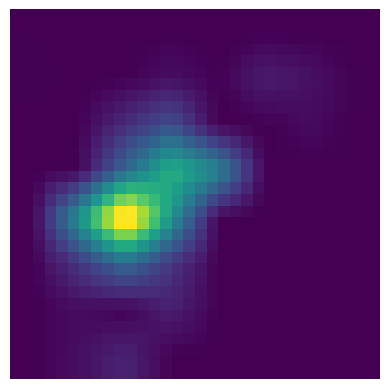

In [623]:
vis = grad_cam_heatmap(img.unsqueeze(dim=0), model)
plt.axis('off')
plt.imshow(vis)

In [624]:
img

tensor([[[ 0.1902, -0.0412, -0.3039,  ..., -0.1118,  0.1314,  0.2137],
         [-0.1431, -0.1549, -0.1824,  ...,  0.1902,  0.2333,  0.3431],
         [-0.2294, -0.1157,  0.0490,  ...,  0.2216,  0.3588,  0.1118],
         ...,
         [ 0.1078,  0.1235,  0.2059,  ...,  0.3863,  0.4255,  0.4098],
         [ 0.1549,  0.3314,  0.4176,  ...,  0.4255,  0.4725,  0.4451],
         [ 0.1627,  0.1824,  0.3471,  ...,  0.4569,  0.4843,  0.4725]],

        [[ 0.2137,  0.0608, -0.2412,  ..., -0.0373,  0.1627,  0.3196],
         [-0.1039, -0.1235, -0.1431,  ...,  0.3000,  0.3353,  0.3431],
         [-0.2098, -0.0490,  0.0765,  ...,  0.3353,  0.3627,  0.1510],
         ...,
         [ 0.1078,  0.1824,  0.3314,  ...,  0.3980,  0.4373,  0.4255],
         [ 0.1314,  0.3275,  0.4255,  ...,  0.4333,  0.4686,  0.4529],
         [ 0.1275,  0.1941,  0.3627,  ...,  0.4608,  0.4725,  0.4725]],

        [[ 0.3000,  0.0451, -0.4647,  ..., -0.0255,  0.2843,  0.3196],
         [-0.0373, -0.1706, -0.2608,  ...,  0

In [625]:
import torch
import torch.nn.functional as F

# Assuming x is your grayscale image tensor with shape (32, 32)
# Add batch_size and channels dimensions to make it (1, 1, 32, 32)
x = torch.tensor(vis).unsqueeze(0).unsqueeze(0)

# Interpolate to the new size (255, 255)
x_interpolated = F.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False).squeeze()

# x_interpolated will now have the shape (1, 1, 255, 255)


In [626]:
orig=torch.tensor(target_image / 255).permute(2, 0, 1)

In [627]:
x_interpolated.repeat_interleave(3, dim=0).view(224, 224, 3)

tensor([[[0.0035, 0.0035, 0.0035],
         [0.0035, 0.0035, 0.0035],
         [0.0035, 0.0035, 0.0035],
         ...,
         [0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000]],

        [[0.0035, 0.0035, 0.0035],
         [0.0035, 0.0035, 0.0035],
         [0.0035, 0.0035, 0.0035],
         ...,
         [0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000]],

        [[0.0035, 0.0035, 0.0035],
         [0.0035, 0.0035, 0.0035],
         [0.0035, 0.0035, 0.0035],
         ...,
         [0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000]],

        ...,

        [[0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000],
         [0.

In [628]:
visualization = show_cam_on_image(
    np.moveaxis(orig.numpy(), 0, -1), x_interpolated, use_rgb=True)

array([[[ 31,  35, 118],
        [ 33,  37, 120],
        [ 37,  40, 123],
        ...,
        [ 78,  89, 169],
        [ 84,  93, 174],
        [ 88,  96, 177]],

       [[ 35,  40, 123],
        [ 39,  44, 127],
        [ 45,  50, 133],
        ...,
        [ 80,  91, 170],
        [ 85,  94, 176],
        [ 89,  97, 179]],

       [[ 42,  49, 132],
        [ 49,  56, 139],
        [ 60,  65, 148],
        ...,
        [ 84,  94, 176],
        [ 88,  97, 178],
        [ 91,  99, 180]],

       ...,

       [[ 74,  71, 139],
        [ 74,  71, 140],
        [ 73,  69, 139],
        ...,
        [138, 150, 228],
        [136, 148, 228],
        [134, 146, 228]],

       [[ 74,  72, 141],
        [ 74,  72, 140],
        [ 73,  70, 141],
        ...,
        [137, 149, 228],
        [136, 148, 228],
        [135, 146, 228]],

       [[ 75,  74, 141],
        [ 74,  73, 142],
        [ 74,  71, 142],
        ...,
        [136, 148, 228],
        [136, 147, 227],
        [135, 146, 228]]], dtype=uint8)
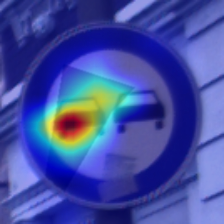

In [629]:
visualization

In [630]:
cv2.imwrite("explaination.png", visualization)

True